<center> <span style="color:indigo">Machine Learning e Inferencia Bayesiana</span> </center> 

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Centro_Universitario_del_Guadalajara_Logo.png/640px-Centro_Universitario_del_Guadalajara_Logo.png" alt="Drawing" style="width: 600px;"/>
</center>
    
<center> <span style="color:DarkBlue">  Tema 13: Redes neuronales, CNN </span>  </center>
<center> <span style="color:Blue"> M. en C. Iván A. Toledano Juárez </span>  </center>

# Redes Neuronales Convolucionales (CNN)

En este notebook exploraremos el funcionamiento de las **redes neuronales convolucionales (CNN)** utilizando PyTorch. El objetivo es comprender su estructura, cómo procesan imágenes y cómo se entrenan para tareas de clasificación supervisada.

Comenzaremos repasando los componentes fundamentales de una red neuronal clásica, para luego construir y comparar una CNN.


In [5]:
# PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader
from helper_functions import accuracy_fn

# TorchMetrics
import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Matplotlib
import matplotlib.pyplot as plt

# Pandas
import pandas as pd

# Random
import random

# Path
from pathlib import Path

# Timer
from timeit import default_timer as timer

# Para barra de progreso
from tqdm.auto import tqdm

# Versiones
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")


PyTorch version: 2.9.0+cpu
torchvision version: 0.24.0+cpu


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.mps.is_available() else "cpu"
print(f"device: {device}")

device: cpu


In [8]:
torch.cuda.is_available()

False

In [7]:
!nvidia-smi

Tue Nov  4 19:08:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.57                 Driver Version: 581.57         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   45C    P8              4W /   38W |     937MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Dataset

``torch.datasets``Aquí se encuentran varios datasets de ejemplo para problemas con imágenes para algunos contextos, como clasificación, detección de objetos, captions de imágenes, clasificación de videos, etc. También contiene una serie de clases baseline para crear datasets personalizados.

La estructura básica de un tensor de imagen en PyTorch es:

\begin{equation}
\text{Tensor shape} = (C, H, W)
\end{equation}

donde $C$ es el número de canales, $H$ la altura y $W$ el ancho.


In [33]:
# Setup datos de entrenamiento
train_data = datasets.MNIST(
    root="/Users/vanotole/Projects/Repos/MachineLearning_InferenciaBayesiana_CUGDL/13_redes_neuronales/mnist_numbers_data", # dónde bajar los datos
    train=True, # obtener datos de entrenamiento
    download=True, # download si no se encuentra
    transform=ToTensor(), # images vienen en formato PIL, pasar a tensores de Torch
    target_transform=None
)

# Setup datos de prueba
test_data = datasets.MNIST(
    root="/Users/vanotole/Projects/Repos/MachineLearning_InferenciaBayesiana_CUGDL/13_redes_neuronales/mnist_numbers_data",
    train=False, # obtener datos de validación
    download=True,
    transform=ToTensor()
)

In [34]:
# forma del primer datos de entrenamiento
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [35]:
image.shape
# es una imagen blanco y negro con 28x28 pixeles

torch.Size([1, 28, 28])

In [36]:
# Qué tantas muestras tenemos?
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [37]:
# Clases
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Shape: torch.Size([1, 28, 28])


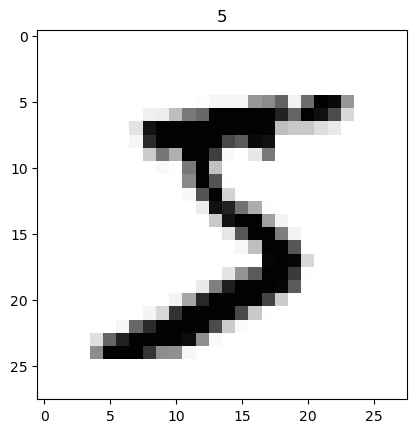

In [38]:
# Plot de la primera imagen
image, label = train_data[0]
print(f"Shape: {image.shape}")
plt.imshow(image.squeeze(), cmap='Greys')
plt.title(label)
plt.show()

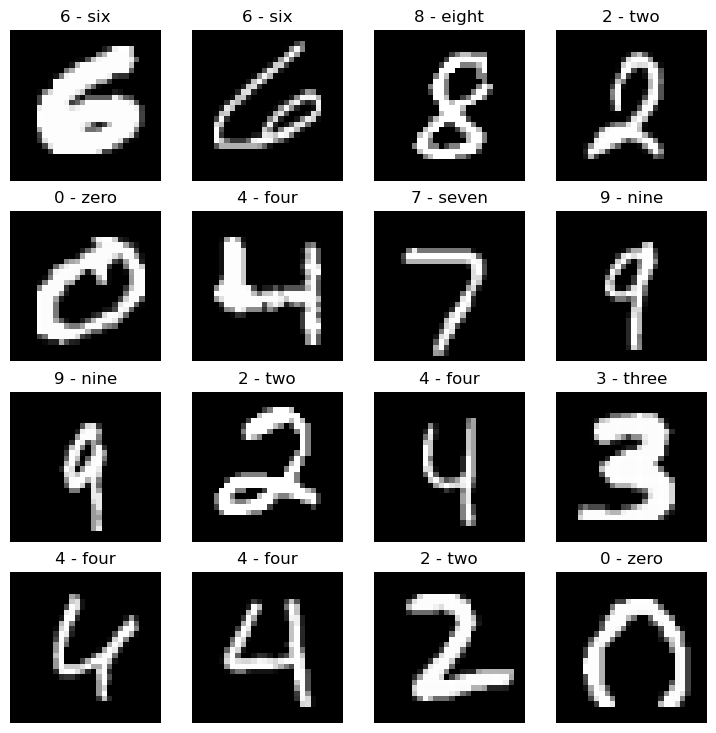

In [39]:
# Plot de más imágenes
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

## Preparación de los datos

La clase `torch.utils.data.DataLoader` permite cargar los datos en *batches* para entrenamiento y validación. El tamaño del batch (`batch_size`) define cuántas muestras se procesan simultáneamente en una pasada del modelo.

Esto ayuda a optimizar el uso de memoria y permite el cálculo de gradientes por lotes:

\begin{equation}
\text{Loss total} = \frac{1}{N} \sum_{i=1}^{N} \text{Loss}_i
\end{equation}


Normalmente se suelen tratar en potencias de 2, empezando por 32 (64,128, etc.)

In [40]:
# Si fija el hiperparámetro batch_size
BATCH_SIZE = 32

# Se realiza el método torch.utils.data.DataLoader para hacer los datasets iterables (batches)
train_dataloader = DataLoader(train_data, # dataset -> iterable
    batch_size=BATCH_SIZE, # cuántas muestras por batch 
    shuffle=True # shuffle para cada época
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Resumen
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Train dataloader (numero de batches): {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Test dataloader (numero de batches): {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x317c383a0>, <torch.utils.data.dataloader.DataLoader object at 0x364b27370>)
Train dataloader (numero de batches): 1875 batches of 32
Test dataloader (numero de batches): 313 batches of 32


In [41]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 9, label size: torch.Size([])


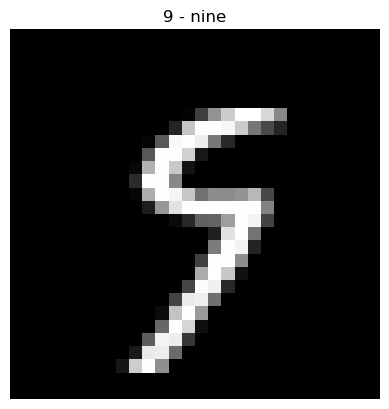

In [42]:
# Una muestra de un batch
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## Construcción de un modelo base

Como punto de partida, implementaremos una red neuronal *fully connected* (sin convoluciones) para comparar su desempeño con una CNN.

La arquitectura general es:

\begin{equation}
\text{Input} \rightarrow \text{Flatten} \rightarrow \text{Linear layers} \rightarrow \text{Activation (ReLU)} \rightarrow \text{Output}
\end{equation}

Este modelo servirá como referencia para observar cómo las convoluciones mejoran la capacidad de extracción de patrones espaciales.


In [43]:
# Capa Flatten
flatten_model = nn.Flatten() # all nn modules function as a model (can do a forward pass)

# Una sola muestra
x = train_features_batch[0]

# Se aplana el outupt
output = flatten_model(x) # forward pass con el modelo basico

# Resumen (ahora es un solo vector de features)
print(f"Shape antes de flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape después de flattening: {output.shape} -> [color_channels, height*width]")

Shape antes de flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape después de flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [44]:
# Model 0
class MNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # la entrada de la red neuronal va a ser en forma de vector de features, como se tenía en notas pasadas
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = numero de features en los datos (784 píxeles)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

Podemos empezar con los siguientes parámetros:

``input_shape``- se trata de un vector con cada uno de los píxeles de la imagen (28X28).
``hidden_units``- numero de neuronas en las capas ocultas, normalmente se empieza por algo pequeño (e.g. 10).
``output_shape``- es un problema multiclase, entonces necesitamos un numero de neuronas equivalente.

In [45]:
torch.manual_seed(88) # semilla aleatoria

# Preparamos el modelo
model_0 = MNISTModelV0(input_shape=784, # uno por cada pixel
    hidden_units=10, # neuronas en las capas ocultas
    output_shape=len(class_names) # una por cada clase
)
model_0.to(device) # se manda a cpu 

MNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

## Función de pérdida y optimizador

Para entrenar el modelo utilizaremos una función de pérdida (*loss function*) y un optimizador.

Por ejemplo:
- **CrossEntropyLoss**: usada para clasificación multiclase.
- **SGD** o **Adam**: ajustan los pesos minimizando la pérdida.

Durante el entrenamiento, los parámetros se actualizan según:

\begin{equation}
\theta_{t+1} = \theta_t - \eta \nabla_\theta L(\theta)
\end{equation}

donde $\eta$ es la tasa de aprendizaje (*learning rate*).


In [46]:
# Loss Function
# Optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [47]:
# Una función para monitorear el tiempo de ejecución

def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time


## Entrenamiento del modelo

Definimos el *loop de entrenamiento* que recorre las épocas y actualiza los parámetros del modelo mediante retropropagación.

En cada iteración:
1. Se realiza una pasada hacia adelante (*forward pass*).
2. Se calcula la pérdida (*loss*).
3. Se ejecuta la retropropagación (*backward pass*).
4. Se actualizan los pesos usando el optimizador.

El gradiente descendente se expresa como:

\begin{equation}
\theta_{t+1} = \theta_t - \eta \frac{\partial L(\theta)}{\partial \theta}
\end{equation}
donde:
- $\theta$ son los parámetros del modelo,  
- $\eta$ es la tasa de aprendizaje,  
- $L(\theta)$ la función de pérdida.

## Loop de entrenamiento

A diferencia de los notebooks pasados, ahora tenemos que iterar sobre los BATCH, así que tenemos que agregar esto. En general los pasos serían los siguientes:

1. Loop de épocas
2. Loop de batch para entrenar (forward, loss/accuracy, zero grad, backpropagation, optimizador), con el cambio de que tenemos que ver la pérdida por batch.
3. Loop de batch para validación (forward, loss), y se calcula la pérdida por batch.
4. Le agregamos el timer.

In [51]:
# semilla aleatoria y timer
torch.manual_seed(88)
train_time_start_on_cpu = timer()

# Número de épocas (se empieza con un número pequeño)
epochs = 3

# Loop de entrenamiento y validación
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Entrenamiento
    train_loss = 0
    
    # Loop de batch
    for batch, (X, y) in enumerate(train_dataloader):

        X, y = X.to(device), y.to(device) # para ponerlos en el hardware correcto
        
        model_0.train() 
        
        # 1. Forward
        y_pred = model_0(X)

        # 2. Se calcula la pérdida (por batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # se añade a la pérdida por época 

        # 3. Zero grad para optimizador
        optimizer.zero_grad()

        # 4. Backpropagation para loss function
        loss.backward()

        # 5. Optimizador
        optimizer.step()

        # Se imprime que tantas muestras se han usado
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    
    ### Validacion
    # Se definenen contadores para acumular loss y accuracy
    test_loss, test_acc = 0, 0 
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:

            X, y = X.to(device), y.to(device) # poner los datos en el hardware correcto
            
            # 1. Forward
            test_pred = model_0(X)
           
            # 2. Se calcula la pérdida (acumuladamente)
            test_loss += loss_fn(test_pred, y) # se añade la perdida por epoca

            # 3. Accuracy (variables preds y y_true tienen que coincidir)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculos sobre la métrica escogida
        # Los calculos se hacen dividiendo por la longitud del dataloader y por batch
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    ## Resumen
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Se calcula tiempo de entrenamiento      
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.30866 | Test loss: 0.29549, Test acc: 91.57%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.29643 | Test loss: 0.28609, Test acc: 92.02%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.28902 | Test loss: 0.28891, Test acc: 91.74%

Train time on mps:0: 8.949 seconds


Aunque no hemos metido capas de convolucion, al parecer los resultados son bastante buenos. A continuación se crea una función que va guardando en un diccionario los resultados por modelo creado.

In [55]:
torch.manual_seed(88)

# La función regresa un diccionario con los resultados del modelo, a partir de los datos en el data_loader
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:

            X, y = X.to(device), y.to(device) # poner los datos en el hardware correcto
            
            # Hacer predicciones con el modelo
            y_pred = model(X)
            
            # Se acumulan los valores de loss y accuracy por batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Se escalan estos valores acumulados para encontrar la media de loss/accuracy por batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # El modelo tiene que haber sido escrito como una clase de python
            "model_loss": loss.item(),
            "model_acc": acc}

In [56]:
# Se calcula el modelo 0 a partir del set de validacion y se hacen pasar por la funcion
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

{'model_name': 'MNISTModelV0',
 'model_loss': 0.2889121174812317,
 'model_acc': 91.7432108626198}

En estos casos, las pruebas también incluirían la inclusión de GPU's para acelerar el cálculo.

## Primer modelo: red neuronal totalmente conectada

En esta sección construimos un primer modelo (`MNISTModelV1`) basado en capas completamente conectadas (sin convoluciones).

Su propósito es servir de referencia para comparar después con una red convolucional.

La arquitectura típica es:
\begin{equation}
\text{Flatten} \rightarrow \text{Linear} \rightarrow \text{ReLU} \rightarrow \text{Linear}
\end{equation}

A través de las funciones `train_step` y `test_step` se separa la lógica del entrenamiento y la validación, favoreciendo la reproducibilidad y claridad del código.


In [57]:
class MNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(), # función de activación
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU() # función de activación
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [58]:
# Parámetros del model 1
torch.manual_seed(88)
model_1 = MNISTModelV1(input_shape=784,
    hidden_units=10,
    output_shape=len(class_names) 
).to(device) # se mandan al gpu (si se encuentra disponible)
next(model_1.parameters()).device # se imprime el hardware utilizado

device(type='mps', index=0)

In [59]:
# Loss/accuracy
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.1)

Como se suelen utilizar varias pruebas de diferentes modelos, es útil ponerlo todo en términos de funciones.

In [60]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Mandar datos a CPU/GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward
        y_pred = model(X)

        # 2. Loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Logits -> pred labels

        # 3. Zero grad
        optimizer.zero_grad()

        # 4. Backpropagation Loss
        loss.backward()

        # 5. Optimizer
        optimizer.step()

    # Loss/Accuracy por epoca
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # poner al modelo en modo eval()
    # Inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Mandar datos a CPU/GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward
            test_pred = model(X)
            
            # 2. Loss/Accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # logits -> pred labels
            )
        
        # Se ajustan metricas de interés y se imprimen
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [61]:
torch.manual_seed(88)

# Se inicializa tiempo
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.66946 | Train accuracy: 78.97%
Test loss: 0.50425 | Test accuracy: 83.45%

Epoch: 1
---------
Train loss: 0.49073 | Train accuracy: 83.91%
Test loss: 0.45780 | Test accuracy: 84.39%

Epoch: 2
---------
Train loss: 0.46498 | Train accuracy: 84.34%
Test loss: 0.44692 | Test accuracy: 84.60%

Train time on mps: 10.420 seconds


El hardware también tiene que coincidir a la hora de comparar modelos. La función creada anteriormente para el diccionario ya contemplaba esto, pero lo volvemos a mencionar.

## Uso de GPU y rendimiento

Recordamos que PyTorch permite acelerar el entrenamiento si se dispone de GPU.


In [65]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = device):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Mandar datos a device
            X, y = X.to(device), y.to(device)  ## En esa línea se considera el hardware
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

In [66]:
# Calculo del model 1 con el hardware
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results


{'model_name': 'MNISTModelV1',
 'model_loss': 0.44692036509513855,
 'model_acc': 84.60463258785943}

In [67]:
model_0_results

{'model_name': 'MNISTModelV0',
 'model_loss': 0.2889121174812317,
 'model_acc': 91.7432108626198}

Parece que al añadir la función de activación ReLU().

En machine learning, el **overfitting** ocurre cuando la precisión de un modelos es alta para los datos de entrenamiento pero baja significativamente para los datos nuevos. Esto puede pasar cuando un modelo es demasiado complejo para los datos de entrenamiento que le estamos dando, causando que "aprenda" demasiado sobre ellos en lugar de ver los patrones más profundos sobre ellos. 

Signos de que un modelo está sobreentrenado:

* La precisión del modelo es muy alta para el set de entrenamiento.
* La precisión del modelo cae significativamente con nuevos datos.
* El score del set de validación es pobre.


https://medium.com/@frederik.vl/interpreting-training-validation-accuracy-and-loss-cf16f0d5329f

Algunas maneras de corregir este problema son las siguientes:

* Usar un modelo menos complejo o totalmente diferente
* Usar un dataset más grande

## Modelo convolucional (CNN)

Ahora introducimos una **red neuronal convolucional (CNN)**, que es especialmente útil para el procesamiento de imágenes.

Su arquitectura típica incluye:
1. **Capas de convolución (`nn.Conv2d`)**: aplican filtros o kernels que extraen características espaciales locales.
2. **Capas de activación (`ReLU`)**: introducen no linealidad.
3. **Capas de *pooling* (`MaxPool2d`)**: reducen la dimensionalidad preservando características relevantes.
4. **Capas lineales finales**: clasifican las representaciones extraídas.

La operación de convolución se define como:
\begin{equation}
S(i,j) = (I * K)(i,j) = \sum_m \sum_n I(i+m, j+n)K(m,n)
\end{equation}
donde:
- $I$ es la imagen de entrada,  
- $K$ el kernel (filtro),  
- $S$ el mapa de activación resultante.


In [69]:
# Convolutional Neural Network
class MNISTModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        # Primera capa de convolucion
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # tamaño del kernel/filtro (normalmente de 3)
                      stride=1, # default
                      padding=1),# opciones = "valid" o "same" 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, # Max Pooling
                         stride=2) # por default el valor del stride es igual al tamaño del kernel
        )

        # Segunda capa de convolucion
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), # Hasta este paso es cuando se aplana el tensor
            # Cada capa de la red comprime y cambia el shape de los datos de entrada
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [70]:
torch.manual_seed(88)
model_2 = MNISTModelV2(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names)).to(device)
model_2

MNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [71]:
# Vemos que le pasa a los datos al propagarlos una vez por la convolucion

torch.manual_seed(88)

# Se crea un batch ficticio de numeros aleatorios
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0] # usamos uno de ellos para prueba
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]") 
print(f"Single image pixel values:\n{test_image}")

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Single image pixel values:
tensor([[[ 0.5554,  0.0996,  1.2011,  ..., -1.2197, -0.8533, -0.7780],
         [-2.6704, -1.4788,  0.0608,  ..., -0.2802,  0.0663,  1.6065],
         [-1.1315,  0.2604, -0.7492,  ..., -0.6404, -1.0006,  0.8939],
         ...,
         [-0.2501,  0.4718,  0.4958,  ..., -0.4726, -0.4318, -0.2954],
         [-0.6530,  0.6729,  0.5291,  ...,  1.3674, -0.0778, -0.8378],
         [-0.2159,  1.5763, -0.9502,  ..., -0.5750,  0.3805,  1.4504]],

        [[ 0.1438, -0.8181,  0.0983,  ..., -1.1509, -1.8556,  0.4562],
         [-0.2338, -1.0445,  1.4583,  ..., -0.8012,  1.8755, -0.9867],
         [-0.3673,  0.4792, -0.0997,  ..., -0.7930, -0.3787, -1.8760],
         ...,
         [ 1.4175, -0.0859,  1.7545,  ...,  0.0699, -0.4082, -0.6488],
         [-0.7485, -0.2292,  0.4921,  ...,  1.5935, -0.7650,

In [72]:
torch.manual_seed(88)

conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0) # "valid" o "same" 

# Se pasan los datos por esta capa
conv_layer(test_image).shape

torch.Size([10, 62, 62])

In [73]:
torch.manual_seed(88)

conv_layer_2 = nn.Conv2d(in_channels=3, # color channels
                         out_channels=10,
                         kernel_size=(5, 5), # kernel de tamaño 5,5 como tupla
                         stride=2,
                         padding=0)

conv_layer_2(test_image.unsqueeze(dim=0)).shape

torch.Size([1, 10, 30, 30])

In [46]:
print(conv_layer_2.state_dict())
# los pesos asignados

OrderedDict([('weight', tensor([[[[ 0.0631,  0.0447,  0.0763, -0.0198, -0.0565],
          [-0.1111, -0.0118,  0.0899, -0.0698, -0.0601],
          [ 0.0832, -0.0432,  0.0320,  0.1120, -0.1058],
          [ 0.0927,  0.0784, -0.0265,  0.1043,  0.1026],
          [ 0.0594,  0.1089,  0.0071, -0.0588, -0.1108]],

         [[ 0.0732,  0.0349,  0.0921, -0.0418,  0.0290],
          [-0.0069, -0.0900,  0.0410, -0.1122, -0.0418],
          [ 0.0934,  0.0809,  0.0320, -0.0915, -0.0418],
          [ 0.0179,  0.0396, -0.1116, -0.0339, -0.0280],
          [-0.0970, -0.0298,  0.0926,  0.0225,  0.1075]],

         [[-0.0791,  0.0494, -0.0419,  0.1127, -0.0289],
          [ 0.0736,  0.0380,  0.0262,  0.0253,  0.0799],
          [-0.0615,  0.0155,  0.0396,  0.0995,  0.1099],
          [ 0.0381, -0.0677, -0.0641,  0.0708,  0.0842],
          [-0.0398,  0.0273,  0.0076,  0.0002, -0.0610]]],


        [[[-0.1016, -0.0103, -0.1025, -0.0747, -0.0103],
          [-0.1061, -0.0052,  0.0704, -0.0931,  0.0373],

In [47]:
# Shapes and weights
print(f"conv_layer_2 weight shape: \n{conv_layer_2.weight.shape} -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]")
print(f"\nconv_layer_2 bias shape: \n{conv_layer_2.bias.shape} -> [out_channels=10]")

conv_layer_2 weight shape: 
torch.Size([10, 3, 5, 5]) -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]

conv_layer_2 bias shape: 
torch.Size([10]) -> [out_channels=10]


In [48]:
# Al hacerlos pasar por una capa nn.MaxPool2D()

# Shape original
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(dim=0).shape}")

# Capa de max pooling
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Se propagan los datos por la capa de convolucion
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Se propagan los datos por la capa MaxPool2D
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 31, 31])


https://datascience.stackexchange.com/questions/64278/what-is-a-channel-in-a-cnn

## Análisis de simensiones en convoluciones y pooling

Vamos a analizar cómo cambian las **dimensiones** de una imagen a medida que pasa por capas convolucionales y de *pooling* en pytorch. Estos cálculos permiten entender cómo las CNN transforman los datos visuales en mapas de características cada vez más abstractas.

#### 1. Imagen inicial

* Shape del lote: `[batch_size, color_channels, height, width] = [32, 3, 64, 64]`
* Shape de una sola imagen: `[3,64,64]`

Cada imagen tiene 3 canales (RGB) y una resolución de 64x64 pixeles.

#### 2. Primera convolución

```python
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0)
```

Esta capa aplica **10 filtros 3x3** sobre la imagen de entrada.

El tamaño de salida se calcularía con las siguientes expresiones,

\begin{equation}
H_{\rm out} = \frac{H_{\rm in} - K + 2P}{S} + 1, \quad W_{\rm out} = \frac{W_{\rm in} - K + 2P}{S} + 1
\end{equation}

de esta forma, $H_{\rm out} = W_{\rm out} = 62$

Entonces la salida sería `[out_channels, height, width] = [10, 62, 62]`

Esto significa que ahora tenemos **10 mapas de características**, cada uno de 62x62 píxeles, resultadod e aplicar diferentes filtros a la imagene original.

#### 3. Segunda convolución con stride

```python
conv_layer_2 = nn.Conv2d(in_channels=3,
                         out_channels=10,
                         kernel_size=5,
                         stride=2,
                         padding=0)
```

Para esta capa, 

\begin{equation}
H_{\rm out} = \frac{64 - 5 + 0}{2} + 1 = 30
\end{equation}

Por lo tanto, la salida es `[1, 10, 30, 30]`. El parámetro `stride=2` hace que el filtro/kernel se desplace dos píxeles a la vez, reduciendo la resolución aproximadamente a la mitad. Cada filtro produce un mapa más pequeño, pero captura patrones más amplios de la imagen.

#### 4. Estructura de los pesos y sesgos

```python
conv_layer_2.weight.shape  # [10, 3, 5, 5]
conv_layer_2.bias.shape    # [10]
```

* Cada filtro/kernel tiene shape `[in_channels, kernel_height, kernel_width] = [3, 5, 5]`.
* Hay **10 filtros/kernels**, uno por cada mapa de salida
* Total de parámetros entrenables,

\begin{equation}
(3 \times 5 \times 5 + 1) \times 10 = 760
\end{equation}

Estos parámetros se optimizan durante el entrenamiento para que los filtros aprendan patrones relevantes como podrían ser bordes, texturas o contornos.

#### 5. Capa de Max Pooling

```python
max_pool_layer = nn.MaxPool2d(kernel_size=2)
```

Esta operación selecciona el valor máximo en cada bloque $2 \times 2$, reduciendo la resolución y conservando la información más importante. La nueva resolución se calcula como

\begin{equation}
H_{\rm out} = \frac{H_{\rm in} - K}{K} + 1
\end{equation}

Lo que resulta en $H_{\rm out} = 31$

Por lo tanto la salida tiene shape `[1,10,31,31]`. Esta primera dimensión corresponde al tamaño de batch.

El *pooling* mantiene el número de canales, pero reduce la altura y el ancho en un 50% en este caso.

## Entrenamiento y validación del modelo convolucional

Se repite el proceso de entrenamiento con el modelo convolucional, utilizando el mismo conjunto de datos.

Compararemos las métricas de desempeño (pérdida y exactitud) entre:
- Modelo base (lineal)
- Modelo mejorado (MLP)
- Modelo convolucional (CNN)

El objetivo es mostrar cómo las CNN capturan mejor las relaciones espaciales en los datos de imágenes.

In [74]:
# Loss / Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.1)

In [75]:
torch.manual_seed(88)

# Tiempo
train_time_start_model_2 = timer()

# Training/Test 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.35322 | Train accuracy: 87.95%
Test loss: 0.06583 | Test accuracy: 97.91%

Epoch: 1
---------
Train loss: 0.07551 | Train accuracy: 97.66%
Test loss: 0.05757 | Test accuracy: 98.20%

Epoch: 2
---------
Train loss: 0.05824 | Train accuracy: 98.22%
Test loss: 0.04451 | Test accuracy: 98.60%

Train time on mps: 14.788 seconds


In [76]:
# Resultados del modelo 2
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'MNISTModelV2',
 'model_loss': 0.04450530558824539,
 'model_acc': 98.60223642172524}

In [77]:
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

compare_results

,model_name,model_loss,model_acc,training_time
0,MNISTModelV0,0.288912,91.743211,8.948989
1,MNISTModelV1,0.446920,84.604633,10.420172
2,MNISTModelV2,0.044505,98.602236,14.788348


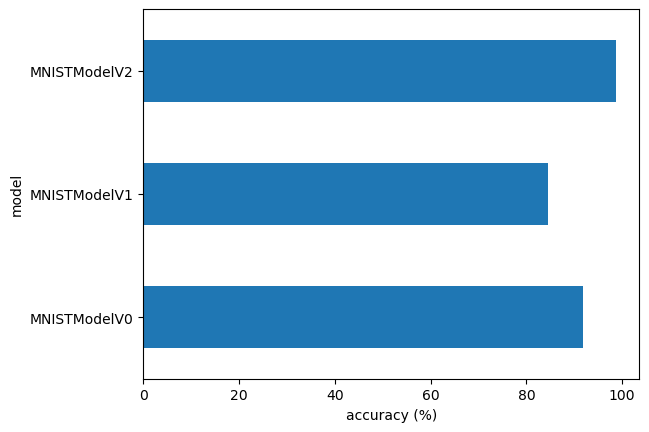

In [78]:
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")
plt.show()

## Evaluación final y predicciones

En esta etapa se evalúa el modelo final sobre el conjunto de prueba, generando predicciones para imágenes no vistas.

El procedimiento general es:
1. Enviar las imágenes a `device`.
2. Aplicar `model.eval()` para desactivar el cálculo de gradientes.
3. Obtener las probabilidades de salida con `torch.softmax`.
4. Asignar la clase más probable.

Esto permite inspeccionar qué tan bien el modelo generaliza fuera del conjunto de entrenamiento.


In [79]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Se prepara la muestra
            sample = torch.unsqueeze(sample, dim=0).to(device) # Se añade una dimensión extra (problemas de versiones)

            # Forward (el modelo tiene un output de logits(raw))
            pred_logit = model(sample)

            # (logit -> pred probability)
            # softmax es aplicado a logits, no a los batch.
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) 

            # Si estuvieran los datos en GPU, aqui se envían a CPU
            pred_probs.append(pred_prob.cpu())

    # las predicciones se vuelven a transformar en un tensor        
    return torch.stack(pred_probs)


In [80]:
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# test/label para el primer datos de validacion
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 2 (2 - two)


In [81]:
# Ahora hacemos las predicciones para todos

pred_probs= make_predictions(model=model_2, 
                             data=test_samples)
pred_probs[:2] # los primeros dos como lista de probabilidades

tensor([[1.7282e-09, 3.7655e-06, 9.9998e-01, 5.2081e-06, 1.1748e-11, 3.4725e-14,
         2.1304e-11, 4.4451e-06, 9.3407e-06, 3.3529e-08],
        [4.4290e-07, 9.9345e-01, 1.8971e-05, 1.1222e-05, 2.7687e-04, 1.9479e-04,
         3.4558e-05, 4.1996e-05, 5.6513e-03, 3.2328e-04]])

Pasamos de predicciones a etiquetas con ``torch.argmax()``, aplicado al output del softmax.

In [82]:
# pasamos de predicciones a etiquetas

pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([2, 1, 2, 4, 6, 6, 4, 9, 1])

In [83]:
test_labels, pred_classes

([2, 1, 2, 4, 6, 6, 4, 9, 1], tensor([2, 1, 2, 4, 6, 6, 4, 9, 1]))

Vemos a ahora sí son de la misma forma que las etiquetas que venían en los datos originales. Ya controlando esto, podemos hacer gráficos para ver las predicciones y ver las imágenes.

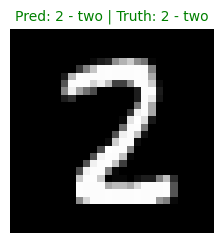

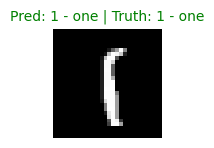

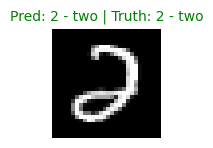

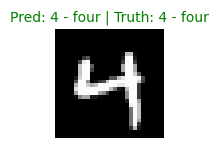

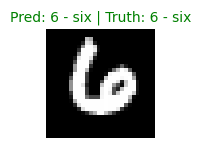

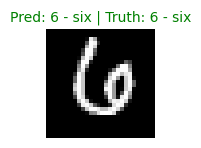

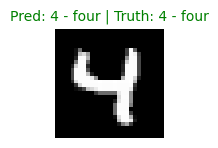

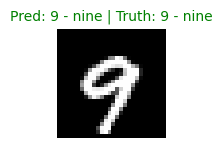

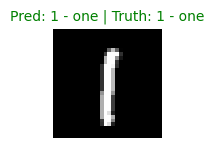

In [84]:
# Grid de imagenes y su prediccion

plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Subplot
  plt.subplot(nrows, ncols, i+1)

  # Se grafica la imagen
  plt.imshow(sample.squeeze(), cmap="gray")

  # Se encuentra la prediccion (en texto)
  pred_label = class_names[pred_classes[i]]

  # Se encuentra el valor real (en texto)
  truth_label = class_names[test_labels[i]] 

  # El titulo incluye tanto la prediccion con el valor real
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Se agrega color verde si coinciden y color rojo si no
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g")
  else:
      plt.title(title_text, fontsize=10, c="r")
  plt.axis(False)
  plt.show()

## Matriz de confusión

Podemos realizar una matriz de confusión sobre las predicciones, utilizando métodos de pytorch como ``torchmetrics.ConfusionMatrix``

In [85]:
# Primero hacemos predicciones

# Barra de progreso
from tqdm.auto import tqdm

# 1. Hacemos predicciones con el modelo 2 ya entrenado
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Se mandan los datos al hardware
    X, y = X.to(device), y.to(device)
    # Forward
    y_logit = model_2(X)
    # logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Si fuera el caso, se ponene directamente los resultados en cpu
    y_preds.append(y_pred.cpu())
# Se concatena la lista de predicciones en un tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

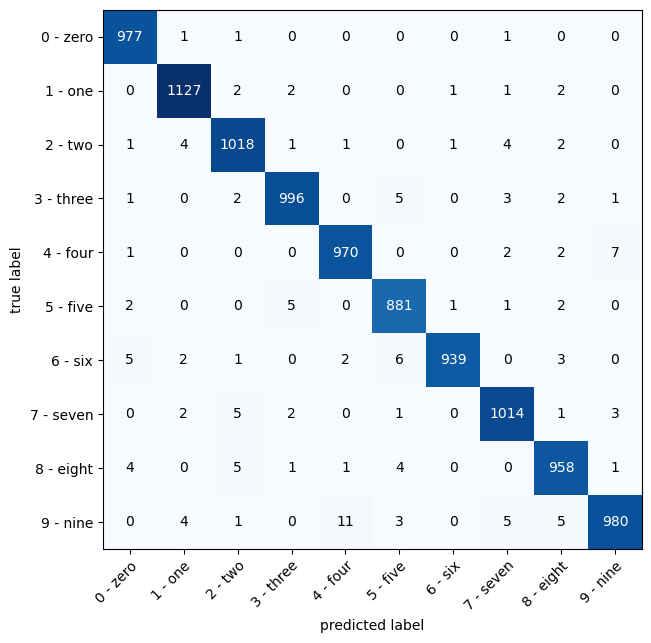

In [86]:
# Se ajusta la matriz de confusion con sus parametros
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# Se grafica la matriz de confusion
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # tensor a numpy para usar matplotlib
    class_names=class_names,
    figsize=(10, 7)
)
plt.show()


Con la matriz de confusión uno podría evaluar ciertos errores del modelo al hacer predicciones. Por ejemplo, que el modelo confunda 2 con 7, etc. Aquí uno toma la decisión de cambiar etiquetas o mejorar el modelo, por ejemplo.

## Guardar el modelo

In [87]:
MODEL_PATH = Path("PyTorchModels")
MODEL_PATH.mkdir(parents=True, # parents directory
                 exist_ok=True # No marcar error si ya existe
)

# Path del archivo
MODEL_NAME = "pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Guardar el modelo
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # solo se guardarían los pesos del state_dict()
           f=MODEL_SAVE_PATH)

Saving model to: PyTorchModels/pytorch_computer_vision_model_2.pth


In [88]:
# Lo cargamos para probarlo

loaded_model_2 = MNISTModelV2(input_shape=1, 
                                    hidden_units=10,
                                    output_shape=10) 

# Se carga el state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Mandar modelo a hardware
loaded_model_2 = loaded_model_2.to(device)


/var/folders/kk/gbkrt22x1jn_jfmqkw6krfw00000gn/T/ipykernel_18673/1844524771.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_2.load_state_dict(torch.load(f=M

In [89]:
# Evaluamos el modelo y vemos que es el mismo
torch.manual_seed(88)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn
)

loaded_model_2_results


{'model_name': 'MNISTModelV2',
 'model_loss': 0.04450530558824539,
 'model_acc': 98.60223642172524}

In [90]:
# Por si son cercanos
torch.isclose(torch.tensor(model_2_results["model_loss"]), 
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-08, # tolerancia absoluta
              rtol=0.0001) # tolerancia relativa


tensor(True)